In [1]:
import os
import time
import numpy as np
import pandas as pd

In [2]:
# from datasets import load_dataset
# dataset = load_dataset("benstaf/nasdaq_2013_2023", data_files="train_data_deepseek_sentiment_2013_2018.csv")
# train = pd.DataFrame(dataset['train'])

In [3]:
# chunks = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/nasdaq_exteral_data.csv", chunksize=1000, header=0)
# from itertools import islice
# for num, chunk in enumerate(islice(chunks, 20)):  # 처음 10개 chunk만 반복
#     print(chunk.Date, chunk.Stock_symbol)

In [4]:
import pandas as pd
tot_data = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/processed_data_v5.csv")

# 감성데이터 row Risk 데이터 붙이기

In [5]:
sentiment_data = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/sentiment_update_prompt_deepseek_nasdaq_news_data.csv")

/tmp/ipykernel_4173343/3946337976.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiment_data = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/sentiment_update_prompt_deepseek_nasdaq_news_data.csv")


In [6]:
sentiment_data.sort_values(by=['Date', 'Tic'], inplace=True)
sentiment_data["Date"] = sentiment_data["Date"].apply(lambda x: x.split(" ")[0])
sentiment_data.rename(columns={'Tic': 'tic'},inplace=True)
sentiment_data.reset_index(drop=True, inplace=True)
sentiment_data.rename(columns={'Date': 'date'},inplace=True)


In [7]:
# 이상치 2017을 1로 변경
sentiment_data["sentiment_update_prompt_deepseek"] = sentiment_data["sentiment_update_prompt_deepseek"].apply(lambda x: 1 if x > 2 else x)

In [8]:
# 기사와 date, tic 겹치는거 확인

indata = sentiment_data[sentiment_data["tic"].isin(tot_data["tic"].unique().tolist())]


In [9]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2018-12-31'
TRADE_START_DATE = '2019-01-01'
TRADE_END_DATE = '2023-12-31'

In [10]:
indata = sentiment_data[sentiment_data["tic"].isin(tot_data["tic"].unique().tolist())]
indata.dropna(subset=["sentiment_update_prompt_deepseek"], inplace=True)
indata.drop_duplicates(subset=['date', 'tic', "Article_title", "Url"], keep="first", ignore_index=True, inplace=True)
indata = indata[indata["date"]>= TRAIN_START_DATE]
indata = indata[indata["date"]<= TRADE_END_DATE]
indata.reset_index(drop=True, inplace=True)

In [11]:
# indata.to_csv("../Task_1_FinRL_DeepSeek_Stock/data/nasdaq_news_data.csv", index=False)

In [12]:
# z = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/nasdaq_news_data.csv")

In [13]:
tot_data_merge_data = pd.merge(tot_data, indata, on=["date", "tic"], how="right")

# 감정분석 결측치

In [14]:
tot_data = tot_data[tot_data["date"] <= TRADE_END_DATE]

In [15]:
# 티커별로 뉴스를 돌면서 해당 날짜에 뉴스가 있는지 확인하고, 뉴스가 있으면 해당 뉴스의 sentiment를 더해준다.
# 뉴스가 없으면 이전의 sentiment를 그대로 사용한다.
# 만약 같은날에 뉴스가 여러개 있으면 그 뉴스들의 sentiment를 모두 더해주고 나눈다.

def fill_ticker_news_mean(price_data, news_data, original_score, columns_name):
    """
    티커별 뉴스 감성 점수를 날짜별로 반영하는 함수.

    Parameters:
        price_data (pd.DataFrame): 주가 데이터 (날짜, 티커 포함)
        news_data (pd.DataFrame): 뉴스 데이터 (날짜, 티커, 감성 점수 포함)

    Returns:
        pd.DataFrame: 날짜별로 티커별 감성 점수가 반영된 데이터
    """
    # 데이터 복사
    price_data = price_data.copy()

    # 날짜별 티커별 감성 점수를 저장할 딕셔너리 생성
    sentiment_dict = {}

    # 티커별로 루프 돌기
    for ticker in price_data["tic"].unique():
        # 특정 티커의 주가 데이터 & 뉴스 데이터 필터링
        ticker_prices = price_data[price_data["tic"] == ticker].copy()
        ticker_news = news_data[news_data["tic"] == ticker]

        # 감성 점수 저장을 위한 리스트
        sentiment_scores = []

        # 이전 감성 점수 초기화 (첫날에는 1으로 설정)
        previous_sentiment = original_score

        # 날짜별로 정렬 후 반복문 실행
        for date in sorted(ticker_prices["date"].unique()):
            # 해당 날짜의 뉴스 필터링
            news_on_date = ticker_news[ticker_news["date"] == date]

            if not news_on_date.empty:
                # 뉴스가 있으면 해당 날짜의 감성 점수 평균 계산
                daily_sentiment = news_on_date[columns_name].mean()

            else:
                # 뉴스가 없으면 이전 감성 점수를 유지
                daily_sentiment = previous_sentiment
            # 만약 뉴스가 없고 이전 감성 점수가 NaN이면 1로 설정
            if news_on_date[columns_name].isnull().sum() == len(news_on_date):
                daily_sentiment = previous_sentiment

            # 감성 점수 리스트에 추가
            sentiment_scores.append(daily_sentiment)

            # 이전 감성 점수 업데이트
            previous_sentiment = daily_sentiment

        # 티커별 감성 점수 저장
        sentiment_dict[ticker] = sentiment_scores

    # 결과를 데이터프레임으로 변환
    sentiment_df = pd.DataFrame(sentiment_dict, index=sorted(price_data["date"].unique()))
    sentiment_df.index.name = "date"
    
    return sentiment_df

### 감성분석 결측치 433개

In [16]:
sentiment_df = fill_ticker_news_mean(tot_data, indata, 1, "sentiment_update_prompt_deepseek")


In [17]:
sentiment_df.reset_index(inplace=True)
sentiment_df.rename(columns={"index": "date"}, inplace=True)
df_sentiment_melted = sentiment_df.melt(id_vars=["date"], var_name="tic", value_name="sentiment_mean")

In [18]:
df_sentiment_melted

,date,tic,sentiment_mean
0,2013-01-02,AAPL,1.0
1,2013-01-03,AAPL,1.0
2,2013-01-04,AAPL,1.0
3,2013-01-07,AAPL,1.0
4,2013-01-08,AAPL,1.0
...,...,...,...
232507,2023-12-22,XEL,2.0
232508,2023-12-26,XEL,2.0
232509,2023-12-27,XEL,2.0
232510,2023-12-28,XEL,2.0


In [19]:
df_sentiment_melted.isna().sum()

date              0
tic               0
sentiment_mean    0
dtype: int64

In [20]:
tot_data = tot_data.merge(df_sentiment_melted, left_on=["date", "tic"], right_on=["date", "tic"], how="left")

In [21]:
import pandas as pd

def generate_past_weights(length: int, scheme: str = "linear") -> list:
    """
    과거 점수에 사용할 가중치 리스트를 생성한다.
    최신 점수가 가장 큰 값을 갖도록 생성됨.

    Parameters:
        length (int): 가중치를 생성할 길이
        scheme (str): 'linear' 또는 'custom'

    Returns:
        list: 가중치 리스트 (오래된 순부터)
    """
    if scheme == "linear":
        return list(range(1, length + 1))
    elif scheme == "custom":
        base, step = 1.0, 0.25
        return [base + step * i for i in range(length)]
    else:
        raise ValueError("weight_scheme은 'linear' 또는 'custom'만 지원됩니다.")


def weighted_average(values: list, weights: list) -> float:
    """
    주어진 값과 가중치로 가중 평균을 계산한다.
    """
    # print(sum(v * w for v, w in zip(values, weights)) / sum(weights))
    return sum(v * w for v, w in zip(values, weights)) / sum(weights)


def get_daily_sentiment(date, ticker_news, sentiment_scores, column, previous_sentiment,
                        past_days, weight_scheme="linear"):
    """
    특정 날짜에 대해 뉴스 기반 감성 점수를 계산하는 함수

    Parameters:
        date (str): 날짜
        ticker_news (DataFrame): 해당 티커의 뉴스 데이터
        sentiment_scores (List[float]): 과거 감성 점수들
        column (str): 감성 점수 컬럼명
        previous_sentiment (float): 이전 감성 점수
        past_days (int): 반영할 과거 일 수
        weights (tuple): (당일 점수 가중치, 과거 평균 가중치)
        weight_scheme (str): 'linear' 또는 'custom'

    Returns:
        float: 최종 감성 점수
    """
    news_on_date = ticker_news[ticker_news["date"] == date]
    # 뉴스 데이터가 비어있고
    if news_on_date.empty:
        # 과거 데이터가 있다면
        if len(sentiment_scores) >= past_days:
            past = sentiment_scores[-past_days:]
            weights_past = generate_past_weights(len(past), scheme=weight_scheme)
            # print(weights_past)
            past_weighted_avg = weighted_average(past, weights_past)
            return past_weighted_avg
        else:
            return previous_sentiment
    # 뉴스 데이터가 있다면
    else:
        non_nan_scores = news_on_date[column].dropna()
        today_mean = non_nan_scores.mean()
    
    # 만약 뉴스가 있고 예측이 결측이라면
    if news_on_date[column].isnull().sum() == len(news_on_date):
        # 과거 데이터가 있다면
        print("결측치", news_on_date)
        if len(sentiment_scores) >= past_days:
            past = sentiment_scores[-past_days:]
            weights_past = generate_past_weights(len(past), scheme=weight_scheme)
            # print(weights_past)
            past_weighted_avg = weighted_average(past, weights_past)
            print("과거 평균", past_weighted_avg)
            return past_weighted_avg
        else:
            print("이전 감성 점수", previous_sentiment)
            return previous_sentiment

    return today_mean  # 일부 결측치가 있는 경우 → NaN 제외 평균만 사용


def fill_ticker_news_past(price_data, news_data, original_score, columns_name,
                          past_days=5, weight_scheme="linear"):
    """
    티커별 뉴스 감성 점수를 날짜별로 반영하는 메인 함수.

    Parameters:
        price_data (pd.DataFrame): 주가 데이터 (날짜, 티커 포함)
        news_data (pd.DataFrame): 뉴스 데이터 (날짜, 티커, 감성 점수 포함)
        original_score (float): 감성 점수 초기값
        columns_name (str): 감성 점수 컬럼명
        past_days (int): 과거 감성 점수 반영 기간
        weights (tuple): (당일 점수, 과거 평균) 가중치
        weight_scheme (str): 'linear' 또는 'custom'

    Returns:
        pd.DataFrame: 날짜별로 티커별 감성 점수가 반영된 데이터
    """
    price_data = price_data.copy()
    sentiment_dict = {}

    for ticker in price_data["tic"].unique():
        ticker_prices = price_data[price_data["tic"] == ticker].copy()
        ticker_news = news_data[news_data["tic"] == ticker]
        sentiment_scores = []
        previous_sentiment = original_score

        for date in sorted(ticker_prices["date"].unique()):
            # print(ticker)
            daily_sentiment = get_daily_sentiment(
                date=date,
                ticker_news=ticker_news,
                sentiment_scores=sentiment_scores,
                column=columns_name,
                previous_sentiment=previous_sentiment,
                past_days=past_days,
                weight_scheme=weight_scheme
            )
            sentiment_scores.append(daily_sentiment)
            previous_sentiment = daily_sentiment

        sentiment_dict[ticker] = sentiment_scores

    sentiment_df = pd.DataFrame(sentiment_dict, index=sorted(price_data["date"].unique()))
    sentiment_df.index.name = "date"
    return sentiment_df


In [22]:
# 예시: 감성 점수 계산
weight_average_five = fill_ticker_news_past(
    price_data=tot_data,
    news_data= indata,
    original_score=1.0,
    columns_name="sentiment_update_prompt_deepseek",
    past_days=5,
    weight_scheme="linear"  # 또는 "linear"
)


In [23]:
weight_average_five.reset_index(inplace=True)
weight_average_five.rename(columns={"index": "date"}, inplace=True)
df_sentiment_melted = weight_average_five.melt(id_vars=["date"], var_name="tic", value_name="sentiment_weight_5")

In [42]:
# tot_data.drop(columns=["sentiment_mean_x"], inplace=True)
# tot_data.rename(columns={"sentiment_mean_y": "sentiment_mean"}, inplace=True)

In [24]:
tot_data = tot_data.merge(df_sentiment_melted, left_on=["date", "tic"], right_on=["date", "tic"], how="left")

In [25]:
# 예시: 감성 점수 계산
weight_average_two = fill_ticker_news_past(
    price_data=tot_data,
    news_data= indata,
    original_score=1.0,
    columns_name="sentiment_update_prompt_deepseek",
    past_days=5,
    weight_scheme="custom"  # 또는 "linear"
)


In [26]:
weight_average_two.reset_index(inplace=True)
weight_average_two.rename(columns={"index": "date"}, inplace=True)
df_sentiment_melted = weight_average_two.melt(id_vars=["date"], var_name="tic", value_name="sentiment_weight_2")

In [27]:
tot_data= tot_data.merge(df_sentiment_melted, left_on=["date", "tic"], right_on=["date", "tic"], how="left")

In [28]:
train = tot_data[tot_data["date"] < TRADE_START_DATE]

In [29]:
train.columns

Index(['date', 'tic', 'ret', 'adjust_low', 'adjust_high', 'adjust_close',
       'adjust_open', 'close', 'high', 'low', 'open', 'return_1m', 'return_3m',
       'return_6m', 'return_12m', 'return_avg', 'mom_12m', 'mom_score',
       'close_1_month', 'close_2_month', 'close_3_month', 'close_4_month',
       'close_5_month', 'close_6_month', 'close_7_month', 'close_8_month',
       'close_9_month', 'close_10_month', 'close_11_month', 'close_12_month',
       'volume', 'SMA_30', 'SMA_60', 'SMA_220', 'SMA_252', 'macd', 'boll_ub',
       'boll_lb', 'rsi', 'cci', 'paa_score', 'gtaa_buy_signal',
       'paa_buy_signal', 'daa_buy_signal', 'momentum_product', 'dm_buy_signal',
       'sentiment_mean', 'sentiment_weight_5', 'sentiment_weight_2'],
      dtype='object')

## 데이터 전처리

In [32]:
# 일자별 1이 넘는 것의 갯수
imp = train[train["sentiment_weight_2"] > 1].groupby("date")["sentiment_weight_2"].count() / train.groupby("date")["sentiment_weight_2"].count()

In [33]:
imp.describe()

count    1510.000000
mean        0.242589
std         0.051955
min         0.023810
25%         0.214286
50%         0.250000
75%         0.273810
max         0.404762
Name: sentiment_weight_2, dtype: float64

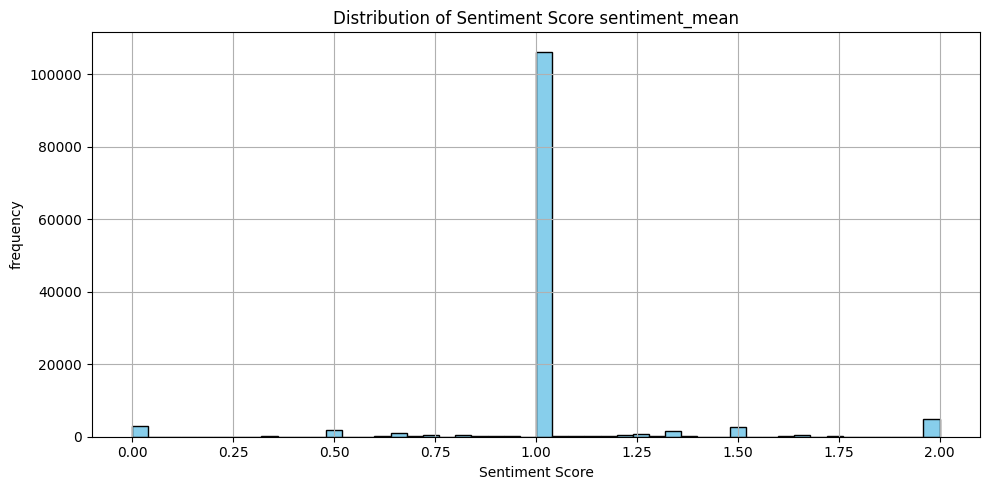

In [34]:
import matplotlib.pyplot as plt
col_name = "sentiment_mean"
plt.figure(figsize=(10, 5))
plt.hist(train[col_name], bins=50, color='skyblue', edgecolor='black')
plt.title(f"Distribution of Sentiment Score {(col_name)}")
plt.xlabel("Sentiment Score")
plt.ylabel("frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
tot_data = tot_data.merge(df_sentiment_melted, left_on=["date", "tic"], right_on=["date", "tic"], how="left")

In [114]:
imp = tot_data[tot_data["tic"]=="MU"]

In [122]:
tot_data["sentiment_mean"].describe()

count    232301.000000
mean          1.043888
std           4.194261
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        2017.000000
Name: sentiment_mean, dtype: float64

## Risk 데이터 Concat 필요

In [30]:
risk_nan = pd.read_csv("data/risk_update_prompt_nan_risk_nan_deepseek_nasdaq_news_data.csv")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [67]:
# real_df = pd.read_csv("data/nasdaq_news_data.csv")
risk_news = pd.read_csv("data/risk_update_prompt_deepseek_nasdaq_news_data.csv")

In [72]:
risk_nan.drop(columns=["Risk_update_prompt_deepseek"], inplace=True)

In [74]:
risk_nan.rename(columns = {"risk_update_prompt_nan" : "risk_update_prompt_deepseek"}, inplace=True)

In [78]:
risk_news = pd.concat([risk_news, risk_nan])

In [79]:
risk_news.reset_index(drop=True, inplace=True)

In [84]:
risk_news["risk_update_prompt_deepseek"].isna().sum()

np.int64(139294)

In [86]:
risk_news.dropna(subset=["risk_update_prompt_deepseek"], inplace=True)

In [92]:
risk_news[risk_news["risk_update_prompt_deepseek"] > 5].head()

,Date,Article_title,Tic,Url,Publisher,Author,Article,Lsa_summary,Luhn_summary,Textrank_summary,Lexrank_summary,Sentiment_deepseek,risk_update_prompt_deepseek
67046,2016-07-08,How The Netflix-Comcast Deal Could Spark A New...,CMCSA,https://www.benzinga.com/news/16/07/8199439/ho...,Manikandan Raman,NaN,NaN,NaN,NaN,NaN,NaN,1.0,413.0
67155,2016-07-11,Congress halfway to passing GMO labeling bill,MDLZ,http://seekingalpha.com/news/3192584-congress-...,Seeking Alpha,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2016.0
67256,2016-07-12,Wells Fargo & Co (WFC): Your Earnings Game Plan,QCOM,https://www.nasdaq.com/articles/wells-fargo-co...,NaN,NaN,InvestorPlace InvestorPlace - Stock Market New...,More From InvestorPlace Trade of the Day: Qual...,More From InvestorPlace Trade of the Day: Qual...,More From InvestorPlace Trade of the Day: Qual...,More From InvestorPlace Trade of the Day: Qual...,1.0,2016.0
130428,2018-08-20,Mid-Morning Market Update: Markets Mostly High...,PEP,https://www.benzinga.com/news/18/08/12231180/m...,Lisa Levin,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2018.0
136687,2018-10-19,"Why Valero Energy, eBay, and New Age Beverages...",EBAY,https://www.nasdaq.com/articles/why-valero-ene...,NaN,NaN,"Friday was an up-and-down day on Wall Street, ...","Valero Energy (NYSE: VLO) , eBay (NASDAQ: EBAY...","Valero Energy (NYSE: VLO) , eBay (NASDAQ: EBAY...","Valero Energy (NYSE: VLO) , eBay (NASDAQ: EBAY...","Valero Energy (NYSE: VLO) , eBay (NASDAQ: EBAY...",0.0,201.0


In [95]:
risk_news = risk_news[risk_news["risk_update_prompt_deepseek"] <= 5]


In [96]:
risk_news.reset_index(drop=True, inplace=True)

In [98]:
risk_news.rename(columns={"Tic": "tic"}, inplace=True)

/tmp/ipykernel_4143307/1452736890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_news.rename(columns={"Tic": "tic"}, inplace=True)


In [ ]:
# risk news랑 결측치 합치기
# risk_news_1 = risk_news[risk_news["risk_update_prompt_deepseek"].notna()]

In [ ]:
# risk_news_1.reset_index(drop=True, inplace=True)

In [ ]:
# tot_risk = real_df.merge(risk_news_1[["Date", "tic", "Url", "Article", "risk_update_prompt_deepseek"]], on=["Date", "tic", "Url", "Article"], how="left")
# sentiment_deepseek 결측치만 다시 저장

# tot_risk[tot_risk["risk_update_prompt_deepseek"].isna()].reset_index(drop=True).to_csv("data/risk_nan_deepseek_nasdaq_news_data.csv", index=False)
# tot_risk[tot_risk.isna().any(axis=1)].to_csv("data/risk_update_prompt_deepseek_nasdaq_news_data.csv", index=False)

In [102]:
risk_news.to_csv("data/risk_update_prompt_deepseek_nasdaq_news_data_v1.csv", index=False)

# Riks 데이터

In [31]:
# # 새로 업데이트된 데이터
risk_news = pd.read_csv("data/risk_update_prompt_deepseek_nasdaq_news_data_v1.csv")
# risk_news.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], inplace=True)

/tmp/ipykernel_4173343/172354972.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  risk_news = pd.read_csv("data/risk_update_prompt_deepseek_nasdaq_news_data_v1.csv")


In [32]:
risk_news.rename(columns={"Stock_symbol": "Tic"}, inplace=True)

In [33]:
risk_news.columns

Index(['Date', 'Article_title', 'tic', 'Url', 'Publisher', 'Author', 'Article',
       'Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary',
       'Sentiment_deepseek', 'risk_update_prompt_deepseek'],
      dtype='object')

In [34]:
risk_news["risk_update_prompt_deepseek"].value_counts(normalize=True)

risk_update_prompt_deepseek
3.0    0.815388
2.0    0.088413
1.0    0.052667
4.0    0.042061
5.0    0.001472
Name: proportion, dtype: float64

In [35]:
risk_news.sort_values(by=['Date', 'tic'], inplace=True)
risk_news["Date"] = risk_news["Date"].apply(lambda x: x.split(" ")[0])


In [36]:
risk_news.rename(columns={'Tic': 'tic'},inplace=True)
risk_news.reset_index(drop=True, inplace=True)
risk_news.rename(columns={'Date': 'date'},inplace=True)

In [37]:
risk_news_df = risk_news[risk_news["tic"].isin(tot_data["tic"].unique().tolist())]

risk_news_df.drop_duplicates(subset=['date', 'tic', "Article_title", "Url"], keep="first", ignore_index=True, inplace=True)

In [38]:
risk_news_df = risk_news_df[indata["date"]>= TRAIN_START_DATE]
risk_news_df = risk_news_df[risk_news_df["date"]<= TRADE_END_DATE]
risk_news_df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_4173343/3687598529.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  risk_news_df = risk_news_df[indata["date"]>= TRAIN_START_DATE]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [39]:
# 티커별로 뉴스를 돌면서 해당 날짜에 뉴스가 있는지 확인하고, 뉴스가 있으면 해당 뉴스의 sentiment를 더해준다.
# 뉴스가 없으면 이전의 sentiment를 그대로 사용한다.
# 만약 같은날에 뉴스가 여러개 있으면 그 뉴스들의 sentiment를 모두 더해주고 나눈다.

def fill_ticker_news_mean(price_data, news_data, original_score, columns_name):
    """
    티커별 뉴스 감성 점수를 날짜별로 반영하는 함수.

    Parameters:
        price_data (pd.DataFrame): 주가 데이터 (날짜, 티커 포함)
        news_data (pd.DataFrame): 뉴스 데이터 (날짜, 티커, 감성 점수 포함)

    Returns:
        pd.DataFrame: 날짜별로 티커별 감성 점수가 반영된 데이터
    """
    # 데이터 복사
    price_data = price_data.copy()

    # 날짜별 티커별 감성 점수를 저장할 딕셔너리 생성
    sentiment_dict = {}

    # 티커별로 루프 돌기
    for ticker in price_data["tic"].unique():
        # 특정 티커의 주가 데이터 & 뉴스 데이터 필터링
        ticker_prices = price_data[price_data["tic"] == ticker].copy()
        ticker_news = news_data[news_data["tic"] == ticker]

        # 감성 점수 저장을 위한 리스트
        sentiment_scores = []

        # 이전 감성 점수 초기화 (첫날에는 1으로 설정)
        previous_sentiment = original_score

        # 날짜별로 정렬 후 반복문 실행
        for date in sorted(ticker_prices["date"].unique()):
            # 해당 날짜의 뉴스 필터링
            news_on_date = ticker_news[ticker_news["date"] == date]

            if not news_on_date.empty:
                # 뉴스가 있으면 해당 날짜의 감성 점수 평균 계산
                daily_sentiment = news_on_date[columns_name].mean()
            else:
                # 뉴스가 없으면 이전 감성 점수를 유지
                daily_sentiment = previous_sentiment
            # 만약 뉴스가 없고, 뉴스 데이터가 모두 결측치인 경우
            # 이전 감성 점수를 그대로 사용
            if news_on_date[columns_name].isnull().sum() == len(news_on_date):
                daily_sentiment = previous_sentiment

            # 감성 점수 리스트에 추가
            sentiment_scores.append(daily_sentiment)

            # 이전 감성 점수 업데이트
            previous_sentiment = daily_sentiment

        # 티커별 감성 점수 저장
        sentiment_dict[ticker] = sentiment_scores

    # 결과를 데이터프레임으로 변환
    sentiment_df = pd.DataFrame(sentiment_dict, index=sorted(price_data["date"].unique()))
    sentiment_df.index.name = "date"
    
    return sentiment_df

In [40]:
risk_df_mean = fill_ticker_news_mean(tot_data, risk_news_df, 3, "risk_update_prompt_deepseek")

In [41]:
risk_df_mean.reset_index(inplace=True)
risk_df_mean.rename(columns={"index": "date"}, inplace=True)
df_risk_df_melted = risk_df_mean.melt(id_vars=["date"], var_name="tic", value_name="risk_mean")

In [42]:
tot_data = tot_data.merge(df_risk_df_melted, left_on=["date", "tic"], right_on=["date", "tic"], how="left")

In [43]:
# 예시: 감성 점수 계산
risk_weight_average_five = fill_ticker_news_past(
    price_data=tot_data,
    news_data= risk_news_df,
    original_score=3.0,
    columns_name="risk_update_prompt_deepseek",
    past_days=5,
    weight_scheme="linear"  # 또는 "linear"
)


In [44]:
risk_weight_average_five.reset_index(inplace=True)
risk_weight_average_five.rename(columns={"index": "date"}, inplace=True)

In [45]:
df_risk_melted = risk_weight_average_five.melt(id_vars=["date"], var_name="tic", value_name="risk_weight_5")

In [46]:
tot_data = tot_data.merge(df_risk_melted, left_on=["date", "tic"], right_on=["date", "tic"], how="left")

In [47]:
# 예시: 감성 점수 계산
risk_weight_average_two = fill_ticker_news_past(
    price_data=tot_data,
    news_data= risk_news_df,
    original_score=3.0,
    columns_name="risk_update_prompt_deepseek",
    past_days=5,
    weight_scheme="custom"  # 또는 "linear"
)


In [48]:
risk_weight_average_two.reset_index(inplace=True)
risk_weight_average_two.rename(columns={"index": "date"}, inplace=True)

In [49]:
risk_weight_average_two

,date,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,...,SNPS,TMUS,TSLA,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL
0,2013-01-02,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,...,3.0,3.0,3.000000,3.000000,3.000000,2.000000,3.000000,3.0,3.000000,3.000000
1,2013-01-03,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,...,3.0,3.0,3.000000,3.000000,3.000000,2.000000,3.000000,3.0,3.000000,3.000000
2,2013-01-04,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,...,3.0,3.0,3.000000,3.000000,3.000000,2.000000,3.000000,3.0,3.000000,3.000000
3,2013-01-07,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,...,3.0,3.0,3.000000,3.000000,3.000000,2.000000,3.000000,3.0,3.000000,3.000000
4,2013-01-08,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,...,3.0,3.0,3.000000,3.000000,3.000000,2.000000,3.000000,3.0,3.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2023-12-22,2.735791,3.207633,2.568015,2.632398,2.983964,2.992993,2.601388,2.806279,3.0,...,3.0,3.0,2.963012,1.723007,1.583802,2.670642,3.032933,3.0,2.923680,2.161104
2764,2023-12-26,2.750627,3.231133,2.573354,2.625074,2.984040,2.992182,2.593853,2.807553,3.0,...,3.0,3.0,2.958559,1.726891,1.570838,2.684047,3.036592,3.0,2.915370,2.065609
2765,2023-12-27,2.746013,3.231479,2.582908,2.621799,2.983793,2.992057,2.591227,2.810957,3.0,...,3.0,3.0,2.956619,1.723177,1.568553,2.688096,3.036351,3.0,2.917356,2.059588
2766,2023-12-28,2.743486,3.229324,2.575756,2.622621,2.983720,2.992019,2.592950,2.816218,3.0,...,3.0,3.0,2.956104,1.722493,1.577190,2.687640,3.035708,3.0,2.920203,2.063812


In [50]:
df_risk_melted_2 = risk_weight_average_two.melt(id_vars=["date"], var_name="tic", value_name="risk_weight_2")

In [51]:
tot_data = tot_data.merge(df_risk_melted_2, left_on=["date", "tic"], right_on=["date", "tic"], how="left")

In [66]:
tot_data.rename(columns={"sentiment_weight_2_x": "sentiment_weight_2"}, inplace=True)
tot_data.drop(columns=["sentiment_weight_2_y"], inplace=True)

## 데이터 전처리

In [57]:
train = tot_data[tot_data["date"] < TRADE_START_DATE]

In [58]:
# 일자별 1이 넘는 것의 갯수
imp = train[train["risk_mean"] < 3].groupby("date")["risk_mean"].count() / train.groupby("date")["risk_mean"].count()

In [59]:
imp.describe()

count    1499.000000
mean        0.101592
std         0.050744
min         0.011905
25%         0.059524
50%         0.095238
75%         0.130952
max         0.297619
Name: risk_mean, dtype: float64

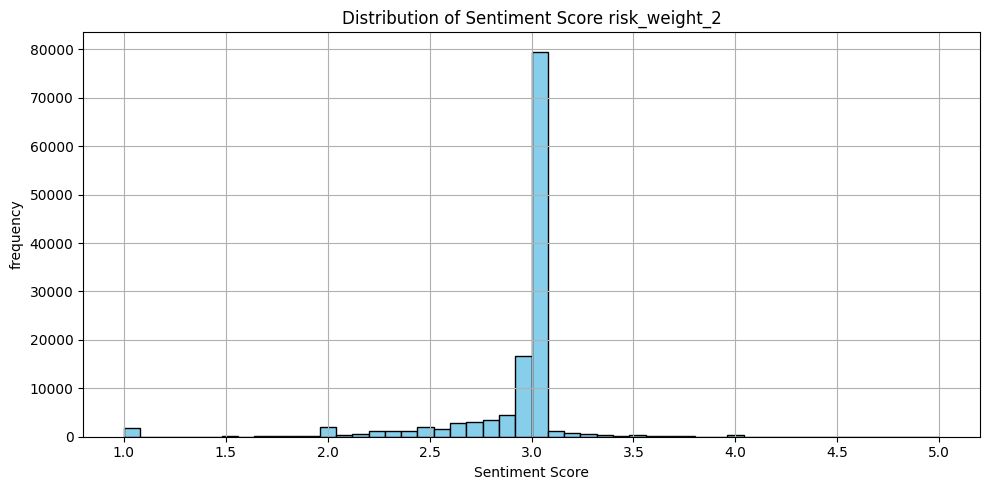

In [60]:
import matplotlib.pyplot as plt
col_name = "risk_weight_2"
plt.figure(figsize=(10, 5))
plt.hist(train[col_name], bins=50, color='skyblue', edgecolor='black')
plt.title(f"Distribution of Sentiment Score {(col_name)}")
plt.xlabel("Sentiment Score")
plt.ylabel("frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# tot_data = tot_data.merge(df_sentiment_melted, left_on=["date", "tic"], right_on=["date", "tic"], how="left")

In [ ]:
# columns_to_load = ['Date', 'Stock_symbol', 'risk_deepseek']
# risk_data = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/risk_deepseek_cleaned_nasdaq_news_full.csv", usecols=columns_to_load)

In [ ]:
# columns_to_load = ['Date', 'Stock_symbol', 'sentiment_deepseek']


# sentiment_data = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/sentiment_deepseek_nasdaq_exteral_data.csv", usecols=columns_to_load)
# sentiment_data = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/sentiment_deepseek_nasdaq_exteral_data.csv")
# train_new = pd.merge(tot_data, sentiment_data, left_on=['date', 'tic'], right_on=['Date', 'tic'], how='left')
# train_new.drop(columns=['Date'], inplace=True)
# risk_data['Date'] = pd.to_datetime(risk_data['Date']).dt.tz_localize(None).dt.strftime('%Y-%m-%d')
# risk_data.rename(columns={'Stock_symbol': 'tic'},inplace=True)
# tot_data = pd.merge(train_new, risk_data, left_on=['date', 'tic'], right_on=['Date', 'tic'], how='left')
# tot_data.drop(columns=['Date'], inplace=True)
# # ticker별로 fillna
# # tot_data = train_new.groupby("tic").apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
# tot_data.reset_index(drop=True, inplace=True)
# tot_data = tot_data.sort_values(['date','tic'])
# tot_data.reset_index(drop=True, inplace=True)
# notsure 1로 채우기
# tot_data["sentiment_deepseek"].fillna(1, inplace=True)
# tot_data["risk_deepseek"].fillna(3, inplace=True)


# minmax scaler & Train, Test Split

In [62]:
tot_data.columns

Index(['date', 'tic', 'ret', 'adjust_low', 'adjust_high', 'adjust_close',
       'adjust_open', 'close', 'high', 'low', 'open', 'return_1m', 'return_3m',
       'return_6m', 'return_12m', 'return_avg', 'mom_12m', 'mom_score',
       'close_1_month', 'close_2_month', 'close_3_month', 'close_4_month',
       'close_5_month', 'close_6_month', 'close_7_month', 'close_8_month',
       'close_9_month', 'close_10_month', 'close_11_month', 'close_12_month',
       'volume', 'SMA_30', 'SMA_60', 'SMA_220', 'SMA_252', 'macd', 'boll_ub',
       'boll_lb', 'rsi', 'cci', 'paa_score', 'gtaa_buy_signal',
       'paa_buy_signal', 'daa_buy_signal', 'momentum_product', 'dm_buy_signal',
       'sentiment_mean', 'sentiment_weight_5', 'sentiment_weight_2_x',
       'risk_mean', 'risk_weight_5', 'risk_weight_2', 'sentiment_weight_2_y'],
      dtype='object')

In [68]:
tot_data.to_csv("data/processed_data_llm_v2.csv", index=False)

In [69]:
def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] <= end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    # data.index = data[target_date_col].factorize()[0]
    return data

In [70]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2018-12-31'
TRADE_START_DATE = '2019-01-01'
TRADE_END_DATE = '2023-12-31'

import yfinance as yf
dji = yf.download("^ndx", start=TRAIN_START_DATE, end=TRADE_END_DATE)
dji.columns = dji.columns.get_level_values(0)
dji=dji.reset_index()
dji.sort_values(by='Date', inplace=True)
dji.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace = True)
df_dji = dji[["date", "close"]]
fst_day = df_dji["close"][0]


dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

dji.rename(columns={"close": "dji"}, inplace=True)

dji.index = pd.to_datetime(dji.index).strftime("%Y-%m-%d")
# tot_df = pd.merge(train_df, dji, how="left", on="date")  # 두 데이터프레임 모두 'date' 컬럼이 있을 때

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [71]:
tot_data = pd.merge(tot_data, dji, how="left", on="date")  # 두 데이터프레임 모두 'date' 컬럼이 있을 때

In [72]:
train = data_split(tot_data, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(tot_data, TRADE_START_DATE,TRADE_END_DATE)

In [73]:
train[["volume", 'SMA_30', 'SMA_60', 'SMA_220', 'SMA_252',
       'macd', 'boll_ub', 'boll_lb', 'rsi', 'cci']]

,volume,SMA_30,SMA_60,SMA_220,SMA_252,macd,boll_ub,boll_lb,rsi,cci
0,560518000.0,16.578904,17.364406,17.928593,17.354068,-0.422438,17.065762,15.128696,53.049633,84.627210
1,6483800.0,35.703000,34.370167,32.987045,32.675119,0.970847,38.990957,34.563043,72.012557,56.332645
2,3761100.0,31.432763,30.620694,29.337021,29.226288,0.423094,33.063813,30.668321,65.880204,156.796526
3,3217561.0,37.935975,38.074119,36.946913,36.803133,0.201278,39.219089,37.530260,56.731627,59.170833
4,2998800.0,33.955000,32.786500,34.709818,34.745635,0.814002,36.799178,32.843822,68.709707,103.484096
...,...,...,...,...,...,...,...,...,...,...
126835,1375400.0,168.145665,172.339832,168.551182,167.335278,-2.989373,186.304555,150.739442,41.467548,-1.138058
126836,4870900.0,57.618739,57.188632,50.919039,51.226210,-1.831340,66.447443,45.835835,21.038323,-57.037439
126837,4095800.0,28.306000,30.326833,26.923227,26.553929,-1.370589,30.667066,23.532934,23.580774,-66.836939
126838,1379600.0,151.201999,141.524000,135.450500,132.697777,3.592677,172.743874,144.886125,50.000000,30.577893


In [74]:
train.groupby("tic")["volume"].agg(["min", "max"]).rename(columns={"min": "vol_min", "max": "vol_max"})

,vol_min,vol_max
tic,,
AAPL,45903600.0,1.460852e+09
ADBE,598200.0,1.642400e+07
ADI,536300.0,1.496300e+07
ADP,488800.0,2.983760e+07
ADSK,355500.0,1.948700e+07
...,...,...
VRTX,340900.0,4.225830e+07
WBA,1367000.0,8.413010e+07
WBD,647400.0,2.568870e+07


In [75]:
def min_max_normalize_by_ticker_train_test(train_df, test_df, columns):
    """
    주어진 컬럼들을 train 기준으로 티커별 min-max 정규화
    
    Parameters:
        train_df (DataFrame): 학습용 데이터
        test_df (DataFrame): 테스트용 데이터
        columns (list): 정규화할 컬럼 리스트
        
    Returns:
        train_df, test_df: 정규화된 결과가 포함된 데이터프레임
    """
    # 티커별로 정규화 통계 계산
    stats = train_df.groupby("tic")[columns].agg(["min", "max"])
    
    # 컬럼명 정리 (MultiIndex → flat column name)
    stats.columns = [f"{col}_{stat}" for col, stat in stats.columns]

    # train/test에 붙이기
    train_df = train_df.merge(stats, on="tic", how="left")
    test_df = test_df.merge(stats, on="tic", how="left")

    # 컬럼별 정규화 수행
    for col in columns:
        min_col = f"{col}_min"
        max_col = f"{col}_max"
        norm_col = f"{col}_norm"

        train_df[norm_col] = (train_df[col] - train_df[min_col]) / (train_df[max_col] - train_df[min_col])
        test_df[norm_col] = (test_df[col] - test_df[min_col]) / (test_df[max_col] - test_df[min_col])

    # 불필요한 min/max 컬럼 제거
    cols_to_drop = [f"{col}_min" for col in columns] + [f"{col}_max" for col in columns]
    train_df.drop(columns=cols_to_drop, inplace=True)
    test_df.drop(columns=cols_to_drop, inplace=True)

    return train_df, test_df


In [76]:
columns_to_normalize = ["volume", 'SMA_30', 'SMA_60', 'SMA_220', 'SMA_252',
                        'macd', 'boll_ub', 'boll_lb', 'rsi', 'cci']

train_df, test_df = min_max_normalize_by_ticker_train_test(train, trade, columns_to_normalize)

In [78]:
train_df.to_csv("./data/train_v4.csv")
test_df.to_csv("./data/test_v4.csv")

In [79]:
train_df.to_csv("./data/train_scaled_v4.csv")
test_df.to_csv("./data/test_scaled_v4.csv")

In [80]:
train = pd.read_csv("./data/train_v4.csv", index_col=0)
trade = pd.read_csv("./data/test_v4.csv", index_col=0)
train_scaled = pd.read_csv("./data/train_scaled_v4.csv", index_col=0)
test_scaled = pd.read_csv("./data/test_scaled_v4.csv", index_col=0)

## Tensor 만들기

In [81]:
window_size = 20
asset_dim = train["tic"].nunique()
# feature_dim = len(features)


In [82]:
train.columns

Index(['date', 'tic', 'ret', 'adjust_low', 'adjust_high', 'adjust_close',
       'adjust_open', 'close', 'high', 'low', 'open', 'return_1m', 'return_3m',
       'return_6m', 'return_12m', 'return_avg', 'mom_12m', 'mom_score',
       'close_1_month', 'close_2_month', 'close_3_month', 'close_4_month',
       'close_5_month', 'close_6_month', 'close_7_month', 'close_8_month',
       'close_9_month', 'close_10_month', 'close_11_month', 'close_12_month',
       'volume', 'SMA_30', 'SMA_60', 'SMA_220', 'SMA_252', 'macd', 'boll_ub',
       'boll_lb', 'rsi', 'cci', 'paa_score', 'gtaa_buy_signal',
       'paa_buy_signal', 'daa_buy_signal', 'momentum_product', 'dm_buy_signal',
       'sentiment_mean', 'sentiment_weight_5', 'sentiment_weight_2',
       'risk_mean', 'risk_weight_5', 'risk_weight_2', 'dji', 'volume_norm',
       'SMA_30_norm', 'SMA_60_norm', 'SMA_220_norm', 'SMA_252_norm',
       'macd_norm', 'boll_ub_norm', 'boll_lb_norm', 'rsi_norm', 'cci_norm'],
      dtype='object')

In [83]:
def _make_data_chaching(real_data):
    """
    데이터를 티커 별로 df대신 딕셔너리로 저장해서 속도를 올리기 위함
    """
    asset_data_dict = {}
    for asset in real_data["tic"].unique():
        asset_data_dict[asset] = real_data[real_data["tic"] == asset]
    return asset_data_dict

In [104]:
feat = [ 'ret', 'adjust_low', 'adjust_high', 'adjust_close',
       'adjust_open', 'return_1m', 'return_3m',
       'return_6m', 'return_12m', 'return_avg', 'mom_12m', 'mom_score',
       'close_1_month', 'close_2_month', 'close_3_month', 'close_4_month',
       'close_5_month', 'close_6_month', 'close_7_month', 'close_8_month',
       'close_9_month', 'close_10_month', 'close_11_month', 'close_12_month',
       'SMA_30', 'SMA_60', 'SMA_220', 'SMA_252', 'macd', 'boll_ub',
       'boll_lb', 'rsi', 'cci', 'momentum_product', 'sentiment_weight_5', 'risk_weight_5', 'volume_norm',
       'SMA_30_norm', 'SMA_60_norm', 'SMA_220_norm', 'SMA_252_norm',
       'macd_norm', 'boll_ub_norm', 'boll_lb_norm', 'rsi_norm', 'cci_norm']

In [105]:
corrr = train[feat].corr()

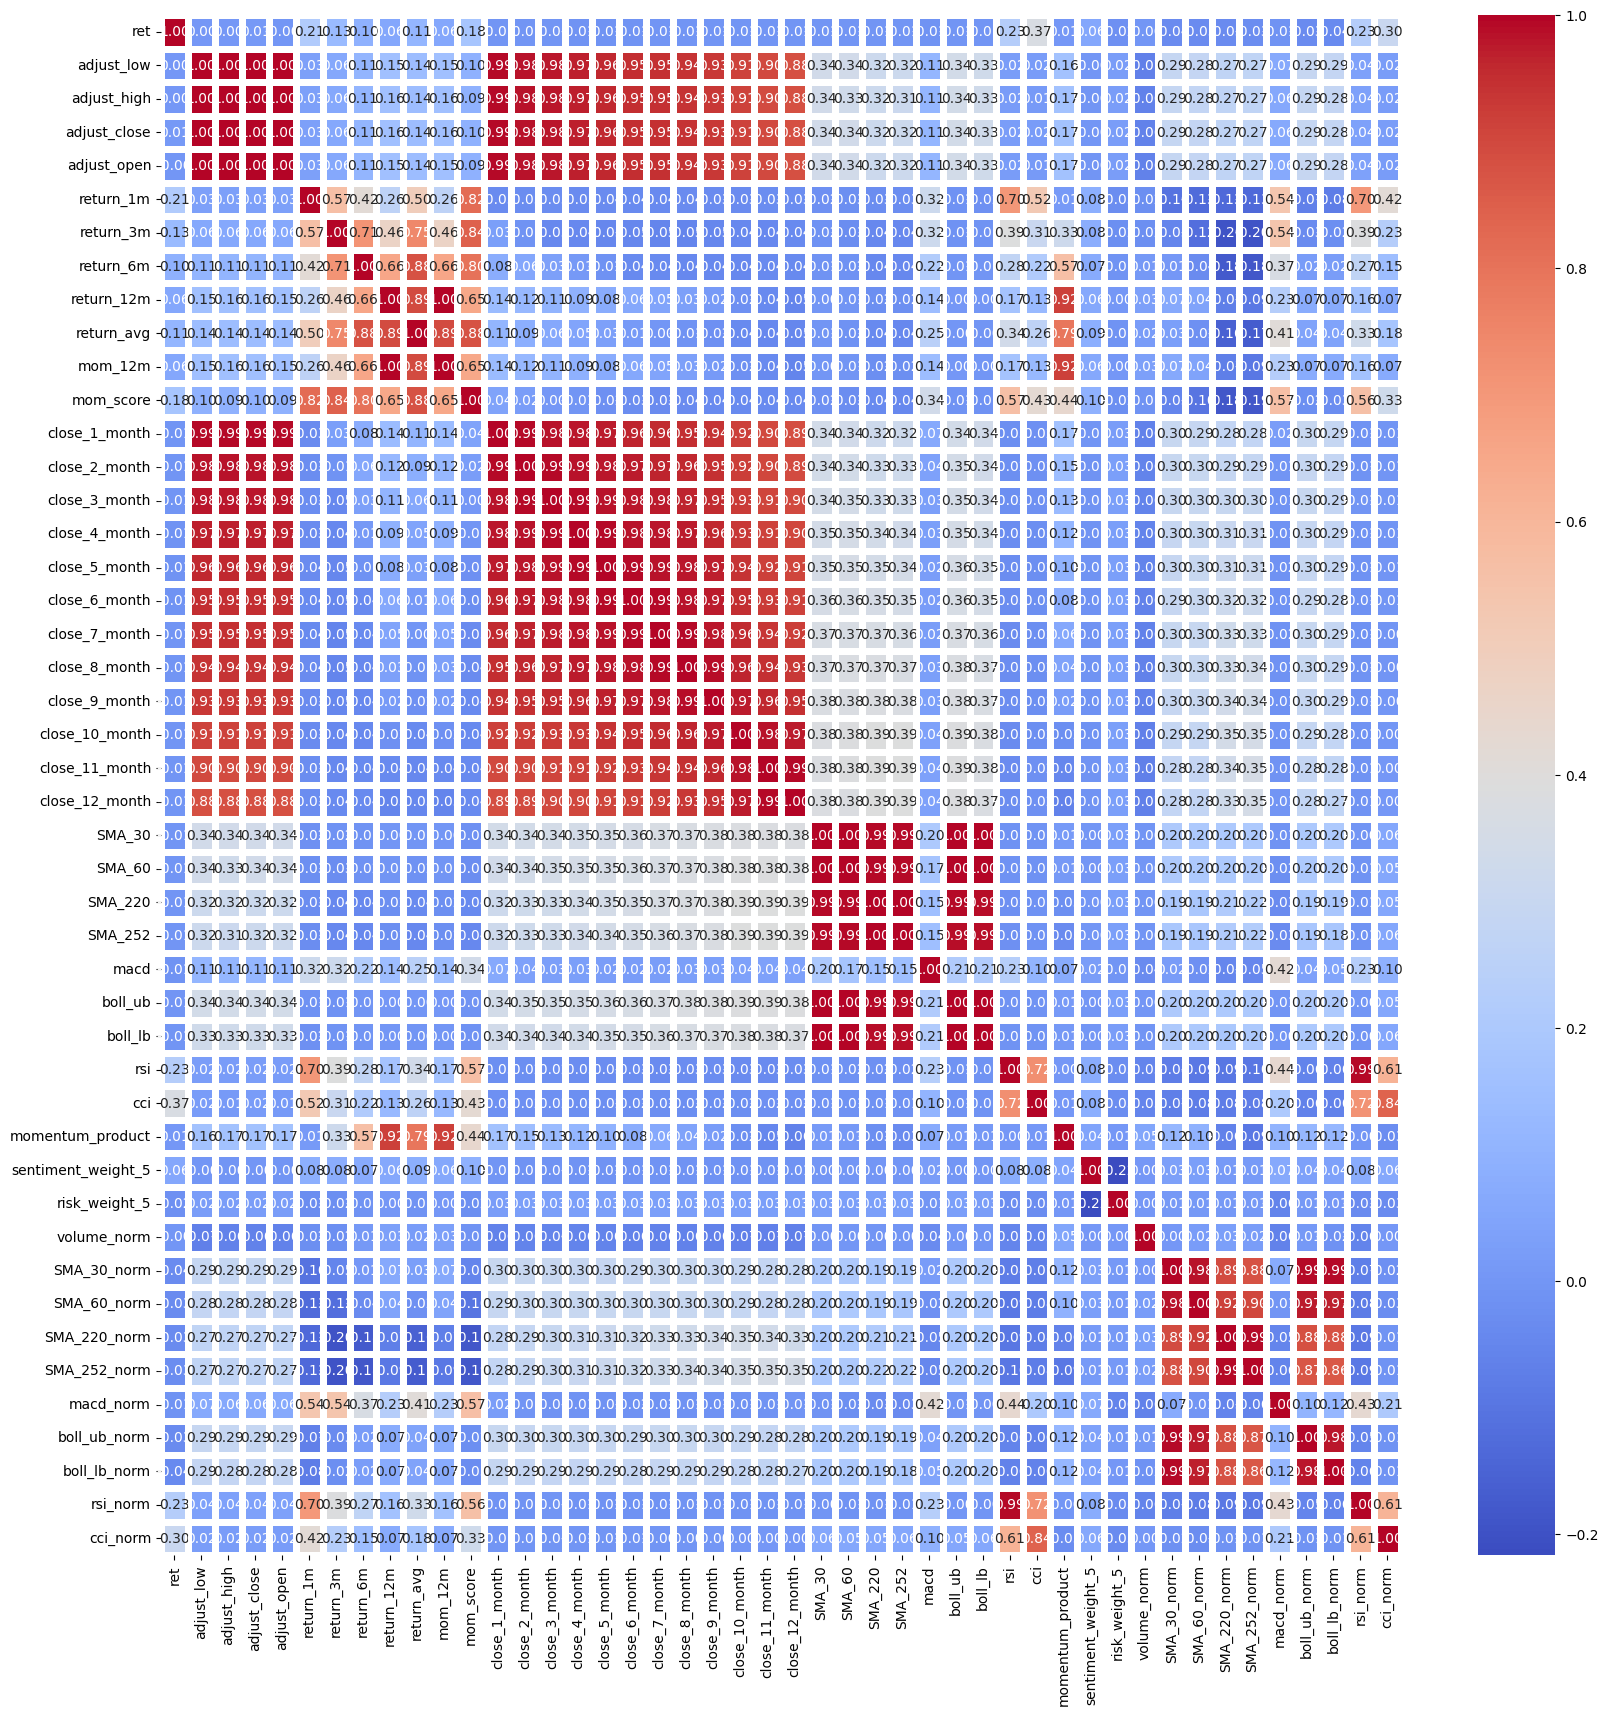

In [106]:
# 히트맵
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(corrr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=5)
plt.show()

In [129]:
feat = [ 'ret', 'adjust_close','return_1m', 'return_3m','mom_12m', 'mom_score',
       'momentum_product', 'sentiment_weight_5', 'risk_weight_5', 'volume_norm',
       'SMA_30_norm','macd_norm', 'boll_ub_norm', 'rsi_norm', 'cci_norm']

In [130]:
corrr = train[feat].corr()

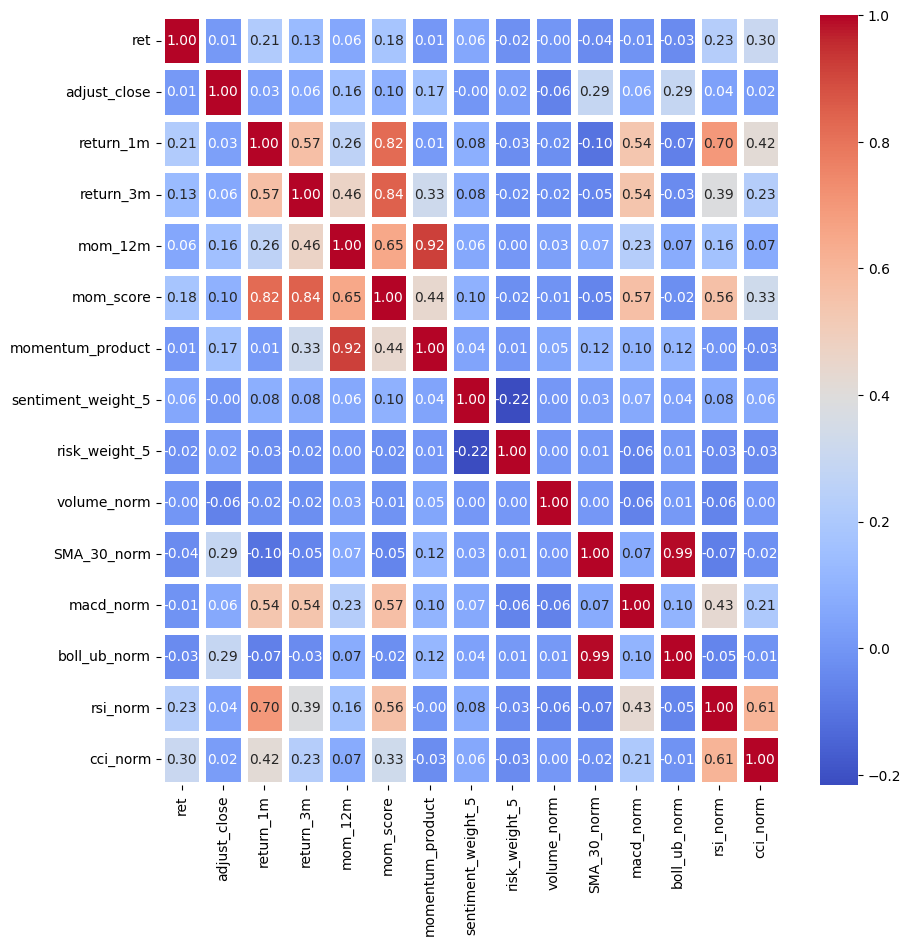

In [131]:
# 히트맵
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(corrr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=5)
plt.show()

In [132]:
feat = [ 'ret', 'adjust_close','return_1m', 'return_3m','mom_12m', 'mom_score',
       'momentum_product', 'sentiment_weight_5', 'risk_weight_5', 'volume_norm',
       'SMA_30_norm','macd_norm', 'boll_ub_norm', 'rsi_norm', 'cci_norm']

In [ ]:
feat = ['ret', 'close', 'return_1m',
       'return_3m', 'mom_12m',
       'mom_score', 'momentum_product', 'sentiment_weight_2', 'risk_weight_2', 'volume_norm', 'SMA_30_norm', 'macd_norm', 'rsi_norm', 'cci_norm']

In [133]:
# rebalance_window = 22

def main_save_tensor(data, window_size):
    # features = ['close', 'high', 'low', 'open', 'volume', 'mom_12m', 'mom_score', 'dm_score', 'macd', 'boll_ub',
    #     'boll_lb', 'rsi', 'cci', 'paa_score', 'sentiment_deepseek', 'risk_deepseek']
    features =[ 'ret', 'adjust_close','return_1m', 'return_3m','mom_12m', 'mom_score',
       'momentum_product', 'sentiment_weight_5', 'risk_weight_5', 'volume_norm',
       'SMA_30_norm','macd_norm', 'boll_ub_norm', 'rsi_norm', 'cci_norm']
    imp = data.reset_index()
    date_index = imp["date"].unique()
    # asset_dim = real_train_data["TICKER"].nunique()
    # feature_dim = len(features)
    # 데이터 캐싱
    asset_data_dict = _make_data_chaching(imp)
    
    
    save_numpy_rebal_dict = {}
    for idx, day in enumerate(date_index):
        rebalance_date = date_index[idx-window_size+1:idx+1]
        if len(rebalance_date) < window_size:
            rebalance_date = date_index[:idx+1]
        total_li = []
        
        for date in rebalance_date:
            save_list = []
            for asset, asset_data in asset_data_dict.items():
                date_data = asset_data[asset_data["date"] == date]
                if not date_data.empty:
                    imp_1 = date_data[features].values
                    save_list.append(imp_1.reshape(-1))
                else:
                    # 데이터가 없으면 0으로 채움
                    save_list.append(np.zeros(len(features)))
            total_li.append(save_list)
        if len(total_li) < window_size:
            padding = [np.zeros(len(features)) for _ in range(len(asset_data_dict))]
            for _ in range(window_size - len(total_li)):
                total_li.insert(0, padding)
        save_numpy_rebal_dict[rebalance_date[-1]] = np.array(total_li)
    return save_numpy_rebal_dict
    


In [134]:
def main_test_tensor(data, window_size):
    features = [ 'ret', 'adjust_close','return_1m', 'return_3m','mom_12m', 'mom_score',
       'momentum_product', 'sentiment_weight_5', 'risk_weight_5', 'volume_norm',
       'SMA_30_norm','macd_norm', 'boll_ub_norm', 'rsi_norm', 'cci_norm']
    imp = data.reset_index()
    date_index = imp["date"].unique()
    # rolling_idx = 0
    # asset_dim = real_train_data["TICKER"].nunique()
    # feature_dim = len(features)
    # 데이터 캐싱
    asset_data_dict = _make_data_chaching(imp)


    save_numpy_rebal_dict = {}

    for idx, day in enumerate(date_index):
        rebalance_date = date_index[idx-window_size+1:idx+1]
        if len(rebalance_date) < window_size:
            continue
        # 윈도우 내 데이터를 저장할 리스트
        total_li = []

        for date in rebalance_date:
            save_list = []
            for asset, asset_data in asset_data_dict.items():
                # 캐싱된 데이터를 사용하여 연산
                date_data = asset_data[asset_data["date"] == date]
                if not date_data.empty:
                    imp_1 = date_data[features].values
                    save_list.append(imp_1.reshape(-1))
                else:
                    # 데이터가 없으면 0으로 채움
                    save_list.append(np.zeros(len(features)))
            
            total_li.append(save_list)
        if len(total_li) < window_size:
            padding = [np.zeros(len(features)) for _ in range(len(asset_data_dict))]
            for _ in range(window_size - len(total_li)):
                total_li.insert(0, padding)
        save_numpy_rebal_dict[rebalance_date[-1]] = total_li
        
    return save_numpy_rebal_dict
    

In [135]:
tot_data = pd.concat([train_scaled, test_scaled])

In [136]:
tot_data.set_index("date", inplace=True)

In [137]:
tot_data = tot_data[tot_data.index >= "2018-11-29"]

In [138]:
import numpy as np

In [139]:
save_sub_episode_dict = main_save_tensor(train_scaled, window_size)

In [140]:
save_test_dict = main_test_tensor(tot_data, window_size)

In [141]:
save_test_dict.keys()

dict_keys(['2018-12-28', '2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-

In [142]:
save_test_dict.pop("2018-12-28")

[[array([-0.007682  ,  7.30397764, -0.17674997, -0.20581599,  0.0753224 ,
         -0.15673351,  1.30619176,  1.        ,  3.        ,  0.08564013,
          0.86505025,  0.01444694,  0.93378304,  0.20019323,  0.50737888]),
  array([-4.81563231e-04,  5.97194922e+00,  1.35498124e-02, -2.75240802e-02,
          4.08481695e-01,  2.34612616e-02,  1.38965217e+00,  1.66666667e+00,
          2.00000000e+00,  1.97481328e-01,  8.88313356e-01,  6.55874988e-02,
          8.88847904e-01,  4.07815463e-01,  6.63144227e-01]),
  array([-0.01322754,  4.00263895,  0.07516717, -0.08038966,  0.07188709,
          0.02296056,  0.99694924,  0.93269841,  2.87460317,  0.15910777,
          0.80065932,  0.6756549 ,  0.81239534,  0.50513297,  0.70931118]),
  array([-1.85719236e-02,  5.13257561e+00,  1.22850486e-02,  2.71833666e-03,
          3.13890615e-01,  3.46317294e-02,  1.29794529e+00,  1.00000000e+00,
          3.00000000e+00,  4.29796108e-02,  9.52026495e-01,  5.07396901e-01,
          9.42385500e-01,  4

In [143]:
save_sub_episode_dict.keys()

dict_keys(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28', '2013-03-01', '2013-03-04', '2013-03-05', '2013-03-06', '2013-03-07', '2013-03-08', '2013-03-11', '2013-03-12', '2013-03-13', '2013-03-14', '2013-03-15', '2013-03-18', '2013-03-19', '2013-03-20', '2013-03-21', '2013-03-22', '2013-03-25', '2013-03-26', '2013-03-27', '2013-03-28', '2013-04-01', '2013-04-02', '2013-04-03', '2013-04-04', '2013-04-05', '2013-04-08', '2013-04-09', '2013-04-10', '2013-04-11', '2013-04-12', '2013-04-

In [144]:
import pickle

In [145]:
with open("./data/test_daily_v4.pkl", "wb") as f:
    pickle.dump(save_test_dict, f)
    
# save_sub_episode_dict = main_save_tensor(train_scaled, window_size)


with open("./data/train_daily_v4.pkl", "wb") as f:
    pickle.dump(save_sub_episode_dict, f)

In [146]:
import torch

In [147]:
def make_subepisode_tensor(data):
    values = []
    for key, value in data.items():
        daily_tensor = []
        for daily_data in value:
            window_tensor = []
            for feature_data in daily_data:
                feature_tensor = torch.tensor(feature_data)
                window_tensor.append(feature_tensor)
            daily_window_tensor = torch.stack(window_tensor)
            daily_tensor.append(daily_window_tensor)
        total_tensor = torch.stack(daily_tensor)
        values.append(total_tensor)
    final_tensor = torch.stack(values)
    return final_tensor
    

def save_all_episodes(episodes, file_name):
    # 리스트를 사전 형태로 저장 (에피소드별 인덱스 포함)
    # data = {str(i): episode for i, episode in enumerate(episodes)}
    torch.save(episodes, file_name)
    print(f"All episodes saved to: {file_name}")
    return episodes


def main_tensor_make(data, file_name):
    episodes = make_subepisode_tensor(data)
    data = save_all_episodes(episodes, file_name)
    return data

In [148]:
episodes = main_tensor_make(save_sub_episode_dict, "./data/daily_data_v4.pt")

All episodes saved to: ./data/daily_data_v4.pt


In [149]:
test_episodes = main_tensor_make(save_test_dict, "./data/test_daily_data_v4.pt")

All episodes saved to: ./data/test_daily_data_v4.pt


In [34]:
episodes.shape

torch.Size([1510, 20, 84, 14])

In [ ]:
episodes.shape

torch.Size([1509, 20, 84, 16])

In [ ]:
test_episodes.shape

torch.Size([1258, 20, 84, 16])

In [ ]:
len(save_sub_episode_dict.keys())

1509

## 환경 적용하기

## Backtesting 확인하기

In [6]:
pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/train_data_deepseek_sentiment_2013_2018.csv")

,Unnamed: 0.1,Unnamed: 0,date,tic,close,high,low,open,volume,day,...,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,llm_sentiment
0,0,0,2013-01-02,AAPL,16.687340,19.821428,19.343929,19.779285,560518000.0,2.0,...,16.879896,16.284159,0.000000,-66.666667,100.000000,16.687340,16.687340,14.68,0.000000,NaN
1,1,1,2013-01-02,ADBE,38.340000,38.730000,37.919998,37.919998,6483800.0,2.0,...,16.879896,16.284159,0.000000,-66.666667,100.000000,38.340000,38.340000,14.68,0.000000,NaN
2,2,2,2013-01-02,ADI,33.714191,44.009998,42.799999,42.799999,3761100.0,2.0,...,16.879896,16.284159,0.000000,-66.666667,100.000000,33.714191,33.714191,14.68,0.000000,3.0
3,3,3,2013-01-02,ADP,39.267780,51.404739,50.702370,50.974541,3217561.0,2.0,...,16.879896,16.284159,0.000000,-66.666667,100.000000,39.267780,39.267780,14.68,0.000000,NaN
4,4,4,2013-01-02,ADSK,36.939999,36.950001,36.049999,36.049999,2998800.0,2.0,...,16.879896,16.284159,0.000000,-66.666667,100.000000,36.939999,36.939999,14.68,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126751,126751,126751,2018-12-28,VRTX,161.419998,164.839996,160.380005,163.520004,966700.0,4.0,...,187.585850,150.832147,44.935760,-57.015038,17.249474,168.107999,172.781499,28.34,53.769986,NaN
126752,126752,126752,2018-12-28,WBA,50.158054,69.080002,67.589996,68.559998,5181800.0,4.0,...,67.057912,46.443012,37.786170,-140.581480,57.411928,57.942806,57.250959,28.34,53.769986,3.0
126753,126753,126753,2018-12-28,WBD,24.639999,25.049999,24.400000,24.850000,3404300.0,4.0,...,31.365200,23.523799,36.637987,-143.645140,51.485596,28.545333,30.469833,28.34,53.769986,NaN
126754,126754,126754,2018-12-28,WDAY,159.559998,162.210007,154.149994,159.270004,1766000.0,4.0,...,173.266137,142.925862,55.732348,49.620993,19.241592,150.292333,141.290333,28.34,53.769986,1.0


In [3]:
def add_sentiment(train, sentiment, column_name='sentiment_deepseek'):
    sentiment_small = sentiment
    train_new = train
    train_new['date'] = pd.to_datetime(train_new['date'])

    # Step 2: Convert 'Date' to datetime without timezone
    sentiment_small['Date'] = pd.to_datetime(sentiment_small['Date']).dt.tz_localize(None)

    # Step 3: Rename 'Stock_symbol' to 'tic' and the sentiment column
    sentiment_small.rename(
        columns={'Stock_symbol': 'tic', column_name: 'llm_sentiment'},
        inplace=True
    )

    # Step 4: Merge train and sentiment_small into a new DataFrame
    train_new = train.merge(
        sentiment_small[['Date', 'tic', 'llm_sentiment']],
        left_on=['date', 'tic'],
        right_on=['Date', 'tic'],
        how='left'
    )

    # Step 5: Drop the additional 'Date' column
    train_new.drop(columns=['Date'], inplace=True)
    return train_new


In [ ]:
columns_to_load = ['Date', 'Stock_symbol', 'sentiment_deepseek']
sentiment = pd.read_csv('sentiment_deepseek.csv', usecols=columns_to_load)

In [ ]:
train_sentiment=add_sentiment(train,sentiment)

In [8]:
fundment = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/fundamental_state.csv")

/tmp/ipykernel_361390/955426586.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  fundment = pd.read_csv("../Task_1_FinRL_DeepSeek_Stock/data/fundamental_state.csv")


In [14]:
set(fundment["tic"].unique()) - set(train["tic"].unique())

{'AAPL.',
 'AEP.PA',
 'AEPPL',
 'AEPPZ',
 'AMD.',
 'AMZN.',
 'ASMLF',
 'AVGOP',
 'AZNCF',
 'CCZ',
 'CMCSK',
 'COST.',
 'CSCO.',
 'DISCB',
 'DISCK',
 'GMCR',
 'GOOG.',
 'HON.WI',
 'LLL.',
 'META.',
 'MSFT.',
 'NVDA.',
 'PE.PA',
 'PE.PB',
 'PE.PC',
 'PE.PD',
 'TMUSP',
 'TSLA.',
 'XCJ',
 'XEL.PA',
 'XEL.PB',
 'XEL.PC',
 'XEL.PD',
 'XEL.PE',
 'XEL.PG'}

In [28]:
fundment["gsector"].unique()

array([45, 20, 55, 35, 50, 30, 25, 10, 60])

In [6]:
import pandas as pd

In [19]:
train["tic"].nunique()

84

In [14]:
len(nasdaq_100_tickers_july_17_2023)

101

In [16]:
set(nasdaq_100_tickers_july_17_2023) - set(train["tic"].unique())

{'ABNB',
 'CEG',
 'CRWD',
 'DDOG',
 'GEHC',
 'GFS',
 'JD',
 'KHC',
 'LCID',
 'MRNA',
 'PDD',
 'PYPL',
 'SGEN',
 'TEAM',
 'TTD',
 'ZM',
 'ZS'}

In [15]:
set(nasdaq_100_tickers_july_17_2023) - imp_data

{'ABNB',
 'CEG',
 'CRWD',
 'DDOG',
 'GEHC',
 'GFS',
 'JD',
 'KHC',
 'LCID',
 'MRNA',
 'PDD',
 'PYPL',
 'SGEN',
 'TEAM',
 'TTD',
 'ZM',
 'ZS'}

In [16]:
# 파일 경로에 맞게 수정합니다.
file_path = '../Task_1_FinRL_DeepSeek_Stock/data/train-00000-of-00001.parquet'

# Parquet 파일 읽기 (pyarrow 또는 fastparquet이 필요)
df = pd.read_parquet(file_path)

In [20]:
df["Stock_symbol"].nunique()

89

In [23]:
len(imp_data)

84

In [24]:
df

,Unnamed: 0.1,Unnamed: 0,Date,Article_title,Stock_symbol,Url,Publisher,Author,Article,Lsa_summary,Luhn_summary,Textrank_summary,Lexrank_summary
0,0,12034.0,2023-12-16 18:00:00 UTC,Is FlexShares STOXX US ESG Select Index Fund (...,AAPL,https://www.nasdaq.com/articles/is-flexshares-...,None,NaN,"Making its debut on 07/13/2016, smart beta exc...","Taking into account individual holdings, Amazo...",Click to get this free report FlexShares STOXX...,Click to get this free report FlexShares STOXX...,"Taking into account individual holdings, Amazo..."
1,1,12068.0,2023-12-15 00:00:00 UTC,Guru Fundamental Report for AAPL,AAPL,https://www.nasdaq.com/articles/guru-fundament...,None,NaN,Below is Validea's guru fundamental report for...,APPLE INC (AAPL) is a large-cap growth stock i...,Detailed Analysis of APPLE INC AAPL Guru Analy...,Detailed Analysis of APPLE INC AAPL Guru Analy...,"Of the 22 guru strategies we follow, AAPL rate..."
2,2,12072.0,2023-12-14 00:00:00 UTC,2 Hot Warren Buffett Stocks That Raised Their ...,AAPL,https://www.nasdaq.com/articles/2-hot-warren-b...,None,NaN,The equity portfolio of Warren Buffett's inves...,Let's dig into the payout enhancements from th...,Let's dig into the payout enhancements from th...,Let's dig into the payout enhancements from th...,Let's dig into the payout enhancements from th...
3,3,12092.0,2023-12-13 00:00:00 UTC,"Technology Sector Update for 12/14/2023: ADBE,...",AAPL,https://www.nasdaq.com/articles/technology-sec...,None,NaN,Tech stocks were mixed Thursday afternoon with...,Apple (AAPL) and Alphabet's (GOOG) Google were...,Apple (AAPL) and Alphabet's (GOOG) Google were...,Apple (AAPL) and Alphabet's (GOOG) Google were...,Apple (AAPL) and Alphabet's (GOOG) Google were...
4,4,12138.0,2023-12-12 00:00:00 UTC,"Up 149% YTD, How High Can Roku (NASDAQ:ROKU) S...",AAPL,https://www.nasdaq.com/articles/up-149-ytd-how...,None,NaN,Media streaming company Roku’s (NASDAQ:ROKU) i...,Roku is also valued cheaper than its bigger co...,Roku is also valued cheaper than its bigger co...,Roku is also valued cheaper than its bigger co...,Roku is also valued cheaper than its bigger co...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61822,61822,NaN,2019-02-17 00:00:00 UTC,"Spotlight On Walmart, Samsung And CAGNY (Stock...",XEL,https://seekingalpha.com/article/4241698-spotl...,Seeking Alpha,NaN,None,None,None,None,None
61823,61823,NaN,2019-02-16 00:00:00 UTC,"Stocks To Watch: Spotlight On Walmart, Samsung...",XEL,https://seekingalpha.com/article/4241661-stock...,Seeking Alpha,NaN,None,None,None,None,None
61824,61824,NaN,2019-02-15 00:00:00 UTC,ALLETE (ALE) Earnings and Revenues Beat Estima...,XEL,http://www.zacks.com/stock/news/355055/allete-...,Zacks,NaN,None,None,None,None,None
61825,61825,NaN,2019-01-24 00:00:00 UTC,Xcel Energy (XEL) Expected to Beat Earnings Es...,XEL,http://www.zacks.com/stock/news/349391/xcel-en...,Zacks,NaN,None,None,None,None,None
